## Importing Required Dependencies

In [509]:
import cv2
from skimage import io
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

## Loading the Dataset

In [3]:
def load_data(data_dir_path):
  dir_names = [dir for dir in os.listdir(data_dir_path)]

  train_labels = []
  test_labels = []
  train_images = []
  test_images = []

  for dir in dir_names:
    label_dir = os.path.join(data_dir_path, dir)
    file_names = [os.path.join(label_dir, file_name) for file_name in os.listdir(label_dir) if file_name.endswith(".ppm")]
    
    # Training images 
    train_file = open(os.path.join(label_dir, 'train.txt')) # open the train.txt file
    train_file_read = train_file.read()
    train_files = train_file_read.split()
    train_file.close()

    # Testing images 
    test_file = open(os.path.join(label_dir, 'test.txt')) # open the test.txt file
    test_file_read = test_file.read()
    test_files = test_file_read.split()
    test_file.close()

    for file_name in file_names:
      if file_name[-15:] in train_files: # matching the filesnames with train filesnames
        img = io.imread(file_name)
        img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_AREA) # resizing the image
        train_images.append(img)
        train_labels.append(int(dir))

      elif file_name[-15:] in test_files: # matching the filesnames with test filesnames
        img = io.imread(file_name)
        img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_AREA) # resizing the image
        test_images.append(img)
        test_labels.append(int(dir))
  return train_images, train_labels, test_images, test_labels

In [4]:
train_images, train_labels, test_images, test_labels = load_data('/content/drive/MyDrive/Computer Vision Assignment/Dataset')

## SIFT

In [5]:
features_extractor = cv2.xfeatures2d.SIFT_create() # create the sift object

train_keypoints = []
train_descriptors = []

test_keypoints = []
test_descriptors = []

for train_img in train_images:
  train_img_keypoints, train_img_descriptors = features_extractor.detectAndCompute(train_img, None) # extract the keypoints and descriptors for training
  train_keypoints.append(train_img_keypoints) # adding each keypoint in the train list 
  train_descriptors.append(train_img_descriptors) # adding each keypoint in the test list 

for test_img in test_images:
  test_img_keypoints, test_img_descriptors = features_extractor.detectAndCompute(test_img, None) # extract the keypoints and descriptors for testing
  test_keypoints.append(test_img_keypoints) # adding each descriptors in the train list 
  test_descriptors.append(test_img_descriptors)# adding each descriptors in the test list 

In [ ]:
# Printing the 1st five images descriptors shape
for i in train_descriptors[:5]:
  print(i.shape)

(38, 128)
(70, 128)
(69, 128)
(52, 128)
(57, 128)


## Visulize the Extracted Features

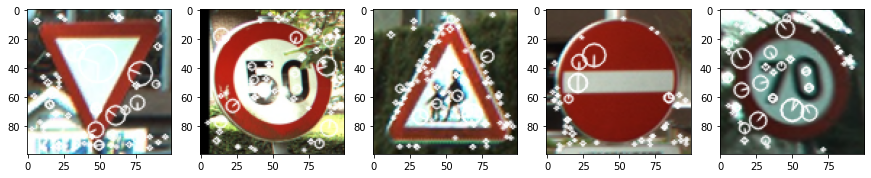

In [30]:
output_images = []
j = 0
plt.figure(figsize = (15,6))
l = [np.random.randint(800) for i in range(5)]
for i in l:
  output_images.append(cv2.drawKeypoints(train_images[i], train_keypoints[i], 0, (255,255,255), flags = cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))
  ax = plt.subplot(1,5,j+1)
  plt.imshow(output_images[j])
  j += 1
plt.show()

## Stack all the training descriptors

In [31]:
train_all_descriptors = []
test_all_descriptors = []

# storing all the descriptors of each image in one list
for train_des in train_descriptors:
  for local_descriptor in train_des:
    train_all_descriptors.append(local_descriptor) 

# storing all the descriptors of each image in one list
for test_des in test_descriptors:
  for local_descriptor in test_des:
    test_all_descriptors.append(local_descriptor)

train_all_descriptors = np.stack(train_all_descriptors)
test_all_descriptors = np.stack(test_all_descriptors)

In [32]:
train_all_descriptors.shape, test_all_descriptors.shape

((46376, 128), (11638, 128))

Now we have all descriptors (128 dimensional vector) across all images. There are around 46376

## Clustering K-means

In [323]:
k = 200 # number of clusters
iters = 1
codebook, variance = kmeans(train_all_descriptors, k, iters, seed = 10) # constructing a codebook

In [505]:
print(f'Codebook Shape{codebook.shape}')

Codebook Shape(200, 128)


## Vector quantization

In [328]:
train_visual_words = []
test_visual_words = []

for train_img_descriptors in train_descriptors:
  train_img_visual_words, distance = vq(train_img_descriptors, codebook)
  train_visual_words.append(train_img_visual_words)

for test_img_descriptors in test_descriptors:
  test_img_visual_words, distance = vq(test_img_descriptors, codebook)
  test_visual_words.append(test_img_visual_words)

In [507]:
# visual words looke like for image 0
print(f'Visual words in Image 0: {train_visual_words[0][:]}')

Visual words in Image 0: [ 21  73  85   0  30 133  48  96 151 151 127 105 162 180   5 172  74 198
  22 104 165 134  96 112 149  63  64 169 162  75   7  16  22  53 188 162
 113 166]


Each of these values 143, 156, 21, 72, 193 etc., represent a centroid from a codebook

## Frequency count

In [332]:
train_frequency_vectors = []
test_frequency_vectors = []

for img_visual_words in train_visual_words:
  img_frequency_vector = np.zeros(k) # k is the number of cluster (200)
  for word in img_visual_words:
    img_frequency_vector[word] += 1 # counting the frequency of the visual words 
  train_frequency_vectors.append(img_frequency_vector) 

for img_visual_words in test_visual_words:
  img_frequency_vector = np.zeros(k) # k is the number of cluster (200)
  for word in img_visual_words:
    img_frequency_vector[word] += 1 # counting the frequency of the visual words 
  test_frequency_vectors.append(img_frequency_vector)

train_frequency_vectors = np.stack(train_frequency_vectors)
test_frequency_vectors = np.stack(test_frequency_vectors)

In [333]:
train_frequency_vectors.shape, test_frequency_vectors.shape

((800, 200), (200, 200))

### complete vocabulary generated

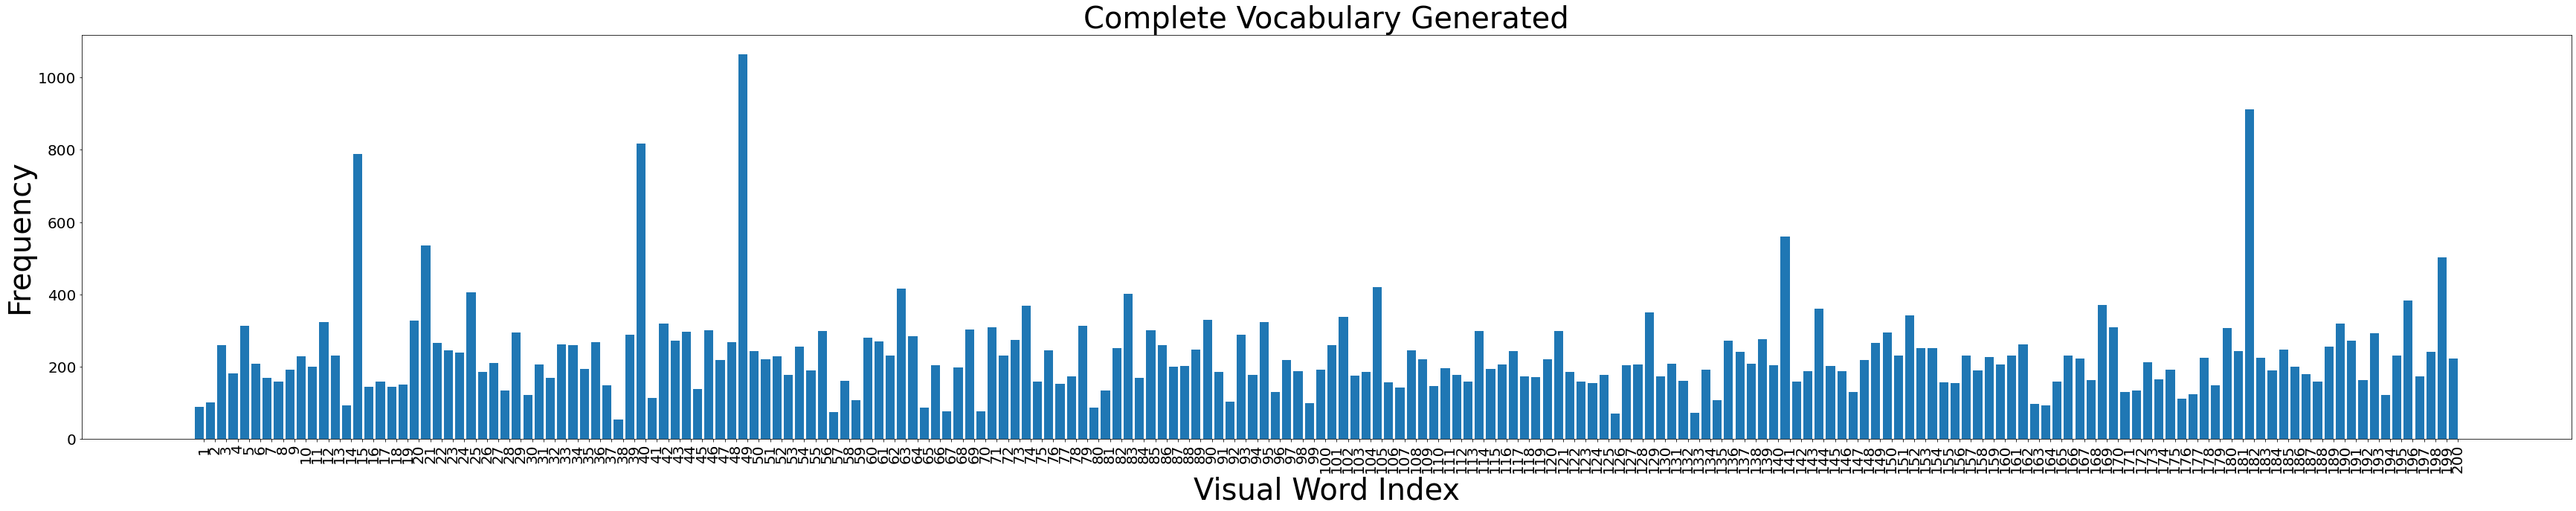

In [360]:
x_scalar = np.arange(1,k+1)
y_scalar = np.array([abs(np.sum(train_frequency_vectors[:,h], dtype=np.int32)) for h in range(k)])
plt.figure(figsize = (60,10))
plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual Word Index", fontsize = 40)
plt.ylabel("Frequency", fontsize = 40)
plt.title("Complete Vocabulary Generated", fontsize = 40)
plt.xticks(x_scalar + 0.4, x_scalar, rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('complete vocabulary generated.jpg')
plt.show()

### Frequencies of 1st 4 images

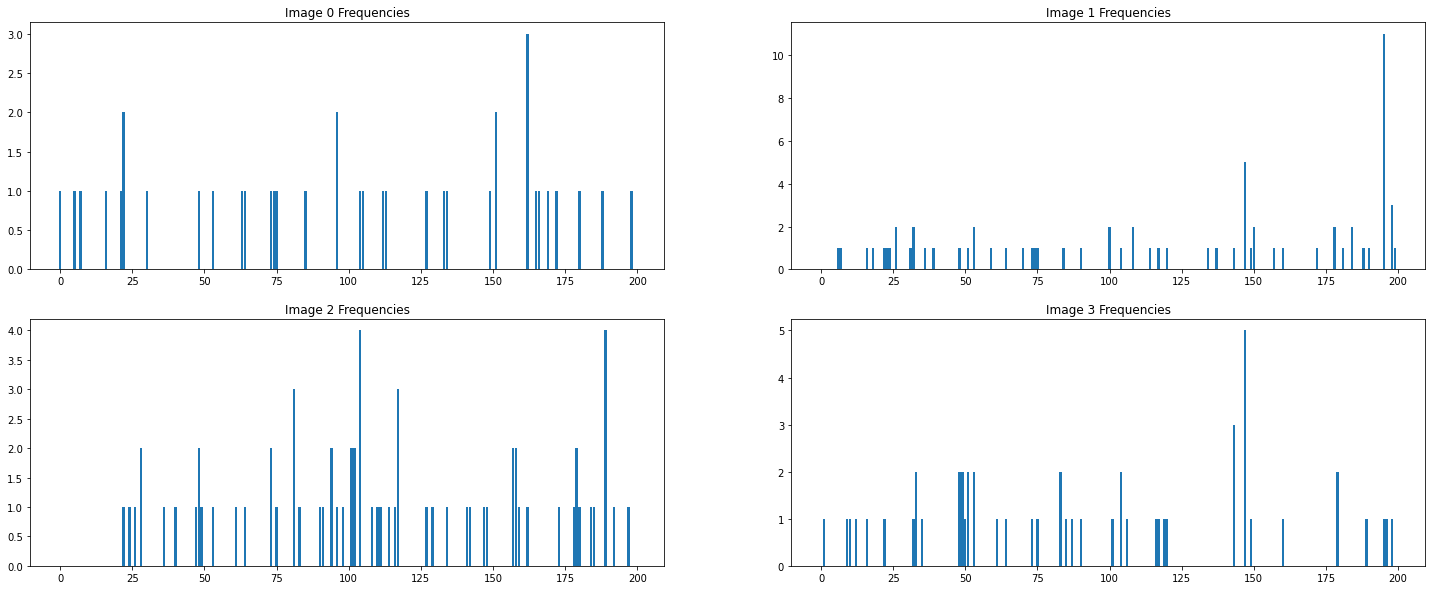

In [364]:
plt.figure(figsize = (25,10))
for i in range(4):
  ax = plt.subplot(2,2,i+1)
  plt.bar(list(range(k)), train_frequency_vectors[i])
  plt.title(f'Image {i} Frequencies')
plt.savefig('Images Frequencies.jpg')
plt.show()

## Scaling the words

In [337]:
# Scaling the words
stdSlr = StandardScaler().fit(train_frequency_vectors)
train_features = stdSlr.transform(train_frequency_vectors) # Normalizing the train features
test_features = stdSlr.transform(test_frequency_vectors) # Normalizing the test features

## SVM Model

In [338]:
#Train an algorithm to discriminate vectors corresponding to positive and negative training images
clf = LinearSVC(max_iter = 10000, random_state = 22)  #Default of 100 is not converging
clf.fit(train_features, np.array(train_labels))

LinearSVC(max_iter=10000, random_state=22)

## Predictions

In [339]:
predictions =  [i for i in clf.predict(test_features)] # predict the test features and store in the list

## Metrics

### Accuracy

In [508]:
accuracy = accuracy_score(test_labels, predictions)
print ("Accuracy = ", np.round(accuracy,2)*100)

Accuracy =  90.0


### Classificarion Report

In [383]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.90      0.95      0.93        20
           2       0.91      1.00      0.95        20
           3       0.95      0.95      0.95        20
           4       0.95      0.95      0.95        20
           5       0.94      0.85      0.89        20
           6       0.75      0.60      0.67        20
           7       0.75      0.75      0.75        20
           8       0.90      0.95      0.93        20
           9       0.95      0.95      0.95        20
          10       0.91      1.00      0.95        20

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200



### Confusion Matrix

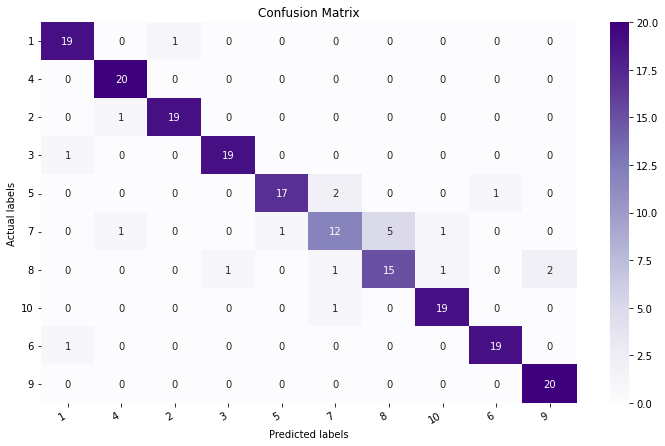

In [400]:
class_names = [1,4,2,3,5,7,8,10,6,9]
def show_confusion_matrix1atrix(confusion_matrix1atrix):
  plt.figure(figsize = (12,7))
  hmap = sns.heatmap(confusion_matrix1atrix, annot=True, fmt="d", cmap="Purples")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Actual labels')
  plt.xlabel('Predicted labels')
  plt.title('Confusion Matrix');
  plt.savefig('Confusion Matrix.jpg')
  plt.show()
cm = confusion_matrix(test_labels, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix1atrix(df_cm)

### Positive and Negative Rate

In [401]:
confusion_matrix1 = pd.DataFrame(cm)
FP = confusion_matrix1.sum(axis=0) - np.diag(confusion_matrix1)  
FN = confusion_matrix1.sum(axis=1) - np.diag(confusion_matrix1)
TP = np.diag(confusion_matrix1)
TN = confusion_matrix1.values.sum() - (FP + FN + TP)

TPR = np.round(TP/(TP+FN),2) # Sensitivity, hit rate, recall, or true positive rate

TNR = np.round(TN/(TN+FP),2)  # Specificity or true negative rate

FPR = np.round(FP/(FP+TN),2)# Fall out or false positive rate

FNR = np.round(FN/(TP+FN),2) # False negative rate

## Predictions Visualization

In [433]:
correctly_class = []
incorrectly_class = []
for i in range(len(predictions)):
  if (test_labels[i] == predictions[i]) == True: 
    correctly_class.append(i) # store all the correctly classified classes
  else:
    incorrectly_class.append(i) # store all the incorrectly classified classes

### Correctly Classified

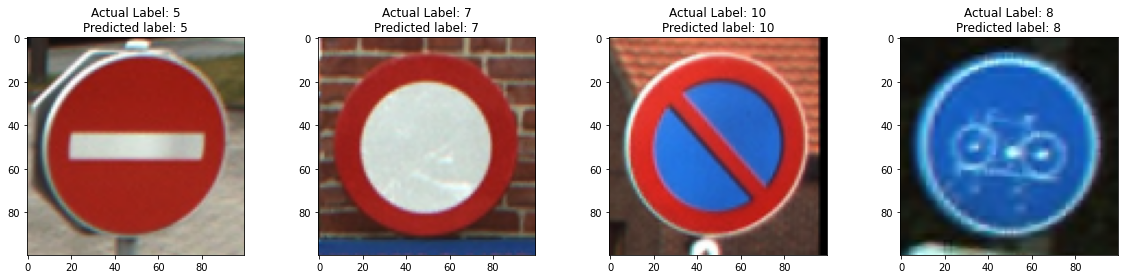

In [460]:
plt.figure(figsize = (20,4))
for i in range(4):
  ax = plt.subplot(1,4,i+1)
  rand_idx = random.randrange(len(correctly_class))
  plt.title(f'Actual Label: {test_labels[correctly_class[rand_idx]]}\nPredicted label: {predictions[correctly_class[rand_idx]]}')
  plt.imshow(test_images[correctly_class[rand_idx]])
plt.savefig('correctly Classified')

### Incorrectly Classified

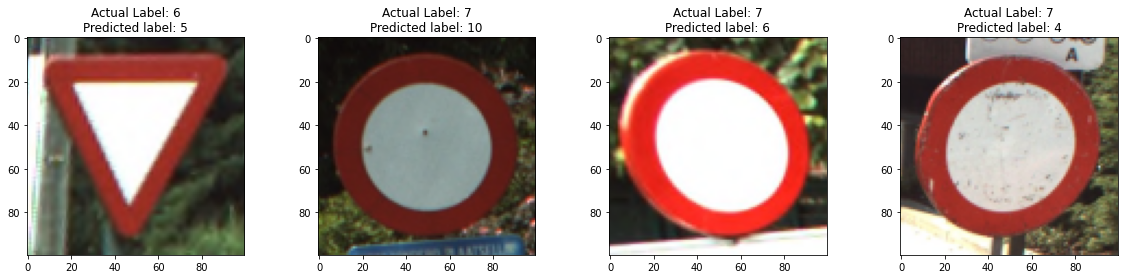

In [458]:
plt.figure(figsize = (20,4))
for i in range(4):
  ax = plt.subplot(1,4,i+1)
  rand_idx = random.randrange(len(incorrectly_class))
  plt.title(f'Actual Label: {test_labels[incorrectly_class[rand_idx]]}\nPredicted label: {predictions[incorrectly_class[rand_idx]]}')
  plt.imshow(test_images[incorrectly_class[rand_idx]])
plt.savefig('Incorrectly Classified')

## Unsupervised Learning

### Kmeans model

In [512]:
kmeans = KMeans(n_clusters = k, init='random', random_state=22)

### Fitting model on train descriptors

In [513]:
kmeans = kmeans.fit(train_all_descriptors)

### Get the labels

In [463]:
labels = kmeans.labels_

### Dimensionality reduction

In [498]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(train_all_descriptors)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [500]:
tx = tsne[:, 0]
ty = tsne[:, 1]

### Cluster visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


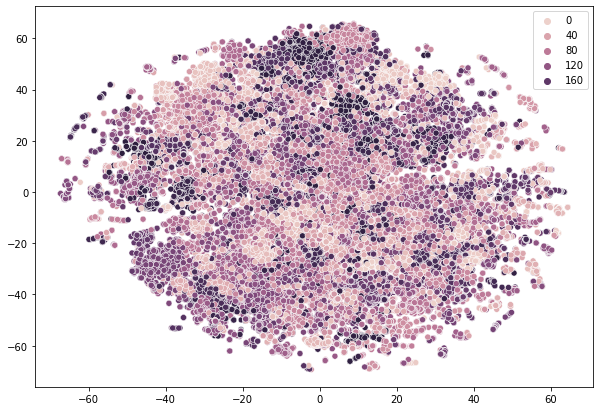

In [504]:
plt.figure(figsize = (10,7))
sns.scatterplot(tx, ty, hue = labels)
plt.savefig('Clutser visualization')